In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import cv2

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [3]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [4]:
DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [5]:
data = []
# path = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        data.append([img, folder])

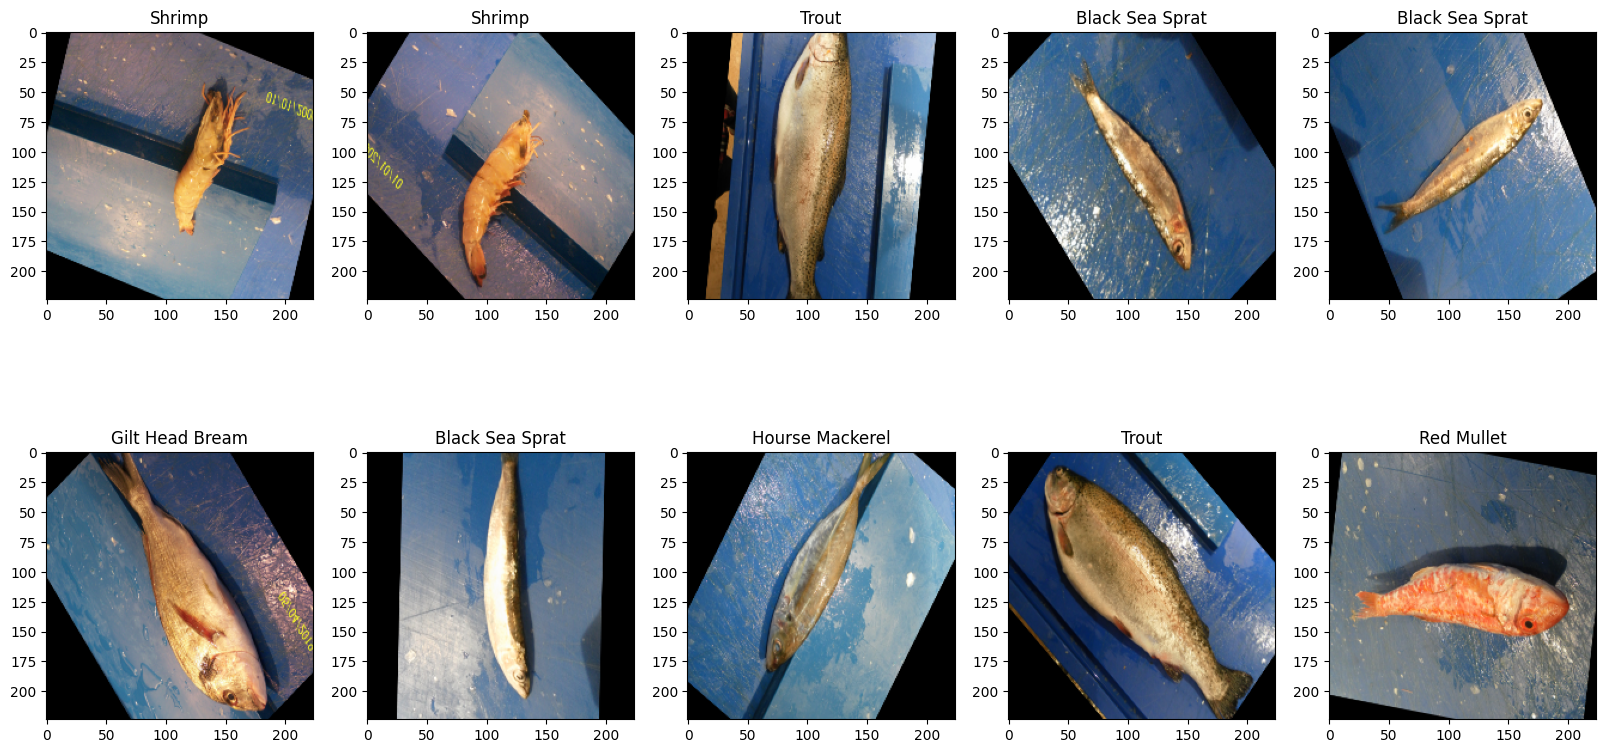

In [6]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [7]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [8]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [9]:
labels = tf.keras.utils.to_categorical(labels, num_classes=9)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [10]:
# reshape images
images = np.array(images)
# images = images.reshape(images.shape[0], 150, 150, 3)
images = images.reshape(images.shape[0], 224, 224, 3)
images.shape

(9000, 224, 224, 3)

In [11]:
# chuẩn hóa images
images = images.astype('float32') / 255.0

In [12]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1000, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((8000, 224, 224, 3), (1000, 224, 224, 3), (8000, 9), (1000, 9))

In [13]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 889, 1: 889, 2: 889, 3: 888, 4: 889, 5: 889, 6: 889, 7: 889, 8: 889}

In [14]:
data_test = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
# path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset'
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        data_test.append([img, folder])

In [15]:
# shuffle data_test
import random
random.shuffle(data_test)

In [16]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [17]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [18]:
test_labels  = tf.keras.utils.to_categorical(test_labels , num_classes=9)
test_labels 

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
# reshape images
test_images = np.array(test_images)
# images = images.reshape(images.shape[0], 150, 150, 3)
test_images = test_images.reshape(test_images.shape[0], 224,224, 3)
test_images.shape

(430, 224, 224, 3)

In [20]:
test_images = test_images.astype('float32') / 255.0

In [30]:
def create_cnn(learning_rate, num_dense_layers, num_dense_nodes, activation, dropout_rate):
    model = Sequential()

    model.add(Conv2D(kernel_size=4, strides=4, filters=32, padding="same", activation=activation, name="layer_conv1"))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(BatchNormalization())

    model.add(Conv2D(kernel_size=2, strides=2, filters=64, padding="same", activation=activation, name="layer_conv2"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(kernel_size=2, strides=1, filters=128, padding="same", activation=activation, name="layer_conv3"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten())

    for i in range(num_dense_layers):
        name = f"layer_dense_{i+1}"
        model.add(Dense(num_dense_nodes, activation=activation, name=name))
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(9, activation="softmax"))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [31]:
# xác định các hyperparameter
dim_learning_rate = Real(low=1e-6, high=1e-2, prior="log-uniform", name="learning_rate")
dim_num_dense_layers = Integer(low=1, high=5, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=5, high=512, name="num_dense_nodes")
dim_activation = Categorical(categories=["relu", "sigmoid"], name="activation")
dim_dropout_rate = Real(low=0.2, high=0.5, prior="log-uniform", name="dropout_rate")

In [32]:
param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
    dim_dropout_rate
]

In [33]:
path_best_model = "cnn_model2.h5"
best_accuracy = 0.0

In [34]:
@use_named_args(param_grid)
def objective(learning_rate, num_dense_layers, num_dense_nodes,activation, dropout_rate):
    print("learning rate: {0:.1e}".format(learning_rate))
    print("num_dense_layers:", num_dense_layers)
    print("num_dense_nodes:", num_dense_nodes)
    print("activation:", activation)
    print()

    model = create_cnn(learning_rate=learning_rate,
                          num_dense_layers=num_dense_layers,
                            num_dense_nodes=num_dense_nodes,
                            activation=activation, dropout_rate=dropout_rate)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)
    history = model.fit(x=train_images,y=train_labels,epochs=10,batch_size=64,validation_split=0.1,callbacks=[learning_rate_reduction])

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy
    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    del model

    return -accuracy

In [35]:
default_parameters = [1e-5, 1, 16, "relu", 0.2]

In [36]:
gp_ = gp_minimize(func=objective,
                    dimensions=param_grid,
                    x0 = default_parameters,
                    acq_func="EI",
                    n_calls=30,
                    random_state=0)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/10
113/113 [==============================] - 43s 361ms/step - loss: 2.2951 - accuracy: 0.1308 - val_loss: 2.1962 - val_accuracy: 0.1388 - lr: 1.0000e-05
Epoch 2/10
113/113 [==============================] - 34s 301ms/step - loss: 2.1895 - accuracy: 0.1547 - val_loss: 2.1869 - val_accuracy: 0.1700 - lr: 1.0000e-05
Epoch 3/10
113/113 [==============================] - 35s 311ms/step - loss: 2.1328 - accuracy: 0.1946 - val_loss: 2.1674 - val_accuracy: 0.2113 - lr: 1.0000e-05
Epoch 4/10
113/113 [==============================] - 34s 304ms/step - loss: 2.0969 - accuracy: 0.2271 - val_loss: 2.1310 - val_accuracy: 0.2512 - lr: 1.0000e-05
Epoch 5/10
113/113 [==============================] - 34s 304ms/step - loss: 2.0588 - accuracy: 0.2493 - val_loss: 2.0778 - val_accuracy: 0.2800 - lr: 1.0000e-05
Epoch 6/10
113/113 [==============================] - 34s 303ms/step - loss: 2.0229 - accuracy: 0.2772 - val_

In [37]:
"Best score=%.4f" % gp_.fun

'Best score=-0.9950'

In [38]:
print("""Best parameters:
=========================
- learning_rate=%.6f
- num_dense_layers=%d
- num_dense_nodes=%d
- activation=%s""" % (gp_.x[0], gp_.x[1], gp_.x[2], gp_.x[3]))

Best parameters:
- learning_rate=0.000213
- num_dense_layers=3
- num_dense_nodes=390
- activation=relu


In [39]:
model = load_model(path_best_model)

In [40]:
result = model.evaluate(x=val_images,y=val_labels)

32/32 [==============================] - 1s 33ms/step - loss: 0.0221 - accuracy: 0.9950


In [41]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.02208876796066761
accuracy 0.9950000047683716


In [42]:
y_pred = model.predict(x=test_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(test_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

14/14 [==============================] - 1s 35ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

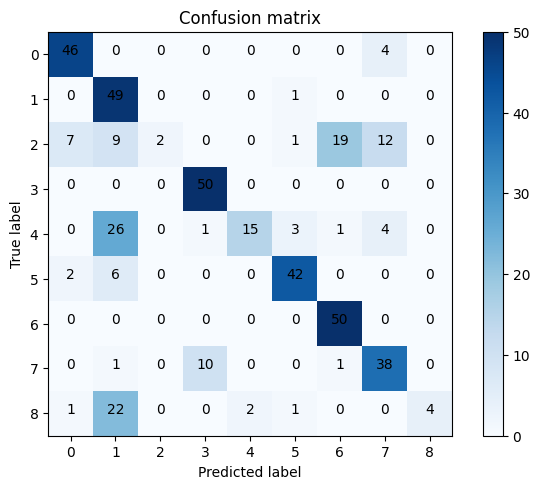

In [43]:
classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [44]:
# tính accuracy, recall, precision
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred_classes)
recall = recall_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")
precision = precision_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")

print("Accuracy: {0:.2%}, Recall: {1:.2%}, Precision: {2:.2%}".format(accuracy, recall, precision))

Accuracy: 68.84%, Recall: 68.84%, Precision: 78.97%
